# Analyse fitted parameters

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score
from math import ceil
import re
from pathlib import Path
from datetime import datetime
import re as _re
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib.colors import to_rgb
import matplotlib.colors as mcolors
import colorsys
from math import ceil
import glob
from pathlib import Path
from typing import List, Tuple, Optional

sys.path.append("../")
from plot_utils import *
from utils import *
from global_variables import *
from escape_map import *
pgm_path = "PGM/"
sys.path.append(pgm_path + "source/")
sys.path.append(pgm_path + "utilities/")
import utilities, Proteins_utils, sequence_logo, plots_utils
import rbm, RBM_utils



E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 2, 'F', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  dmean_v_dw = np.dot(s1.T, V)
E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  mean_V = np.dot(weights, V) / sum_weights
C:\Users\maria\AppData\Roaming\Python\Python312\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Loaded 29 KD vectors
Loaded 2 KD vectors
Loaded 671 KD vectors
Loaded 438 KD vectors


In [2]:


# --- inputs ---
PARAM_DIR = Path("../params_by_period_0.03_m1_m8_m8")  # folder containing param_period_*.csv
ab_class_df = pd.read_csv("../exp_data/ab_classification.csv")

# --- helpers ---
def _extract_period_label(p: Path) -> str:
    """
    From filename like 'param_period_2021-01-01.csv' -> '2021-01-01'.
    If your label format differs, adjust the regex.
    """
    m = re.search(r"param_period_([0-9]{4}-[0-9]{2}-[0-9]{2})\.csv$", p.name)
    if not m:
        # try YYYY-MM
        m2 = re.search(r"param_period_([0-9]{4}-[0-9]{2})\.csv$", p.name)
        if not m2:
            raise ValueError(f"Cannot parse period label from {p.name}")
        return m2.group(1) + "-01"
    return m.group(1)

def _period_to_datetime(label: str) -> pd.Timestamp:
    # label like 'YYYY-MM-DD'
    return pd.to_datetime(label, format="%Y-%m-%d", errors="coerce")

# --- load all params and build long df ---
rows = []
for csv_path in sorted(PARAM_DIR.glob("param_period_*.csv")):
    period_label = _extract_period_label(csv_path)          # 'YYYY-MM-DD'
    period_dt = _period_to_datetime(period_label)

    df = pd.read_csv(csv_path)
    if df.empty:
        continue
    row0 = df.iloc[0]

    beta_rbm = float(np.exp(row0["raw_beta"]))
    ace2 = float(row0["raw_ace2"])

    # any column that starts with 'raw_c_' is an antibody
    ab_cols = [c for c in df.columns if c.startswith("raw_c_")]
    for c in ab_cols:
        ab_name = c.removeprefix("raw_c_")
        conc = float(row0[c])
        #put between -12 and -5
        if conc < -12:
            conc = -12
        if conc > -5:
            conc = -5
        rows.append(
            {
                "time_period": period_dt,
                "beta_rbm": beta_rbm,
                "ACE2": ace2,
                "ab_names": ab_name,
                "conc": conc,
            }
        )

df_conc = pd.DataFrame(rows)
df_conc = df_conc.sort_values("time_period").reset_index(drop=True)

# --- join with classification to get class per antibody ---
# ab_class_df: condition=ab name, condition_subtype = antibody class (e.g., 'class 1')
ab_class_df = ab_class_df.rename(columns={"condition": "ab_names"})
df_merged = df_conc.merge(ab_class_df[["ab_names", "condition_subtype"]],
                          on="ab_names", how="left")

# Optional: warn on antibodies missing a class
missing = df_merged["condition_subtype"].isna().sum()
if missing:
    print(f"[warn] {missing} entries have no class in ab_class_df (left as NaN).")

# --- 1) Plot class mean conc vs time ---
class_mean = (
    df_merged.groupby(["time_period", "condition_subtype"], dropna=False)["conc"]
    .mean()
    .reset_index()
)

# Pivot for multi-line plot
pivot_class = class_mean.pivot(index="time_period", columns="condition_subtype", values="conc")
pivot_class = pivot_class.sort_index()

ace2_per_period = (
    df_conc.drop_duplicates(["time_period"])[["time_period", "ACE2"]]
    .sort_values("time_period")
)
beta_per_period = (
    df_conc.drop_duplicates(["time_period"])[["time_period", "beta_rbm"]]
    .sort_values("time_period")
)



# --- optional: save df_conc for downstream use ---
# df_conc.to_csv("df_conc.csv", index=False)


C:\Users\maria\AppData\Local\Temp\ipykernel_22228\1324070141.py:19: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


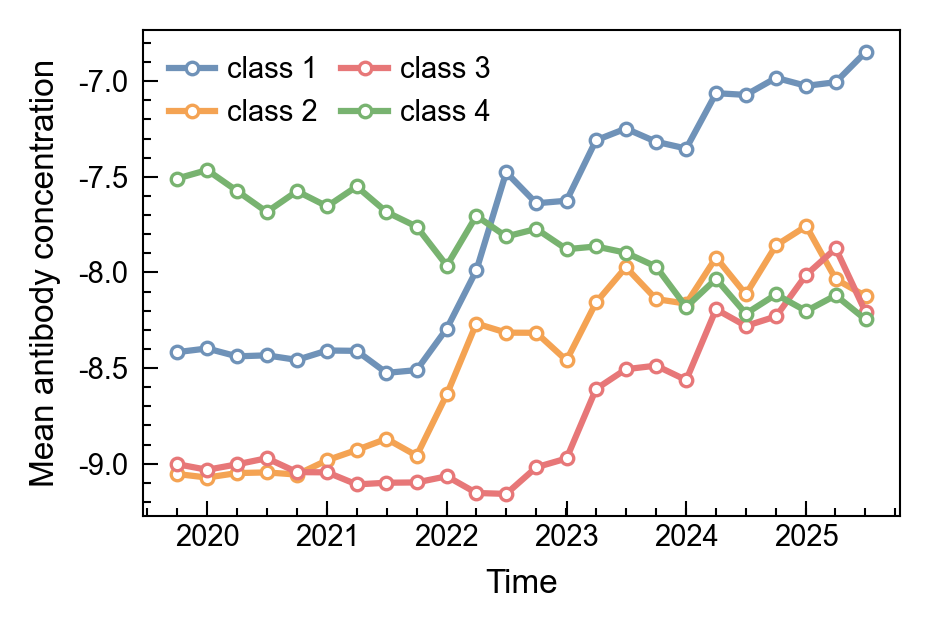

In [3]:
nature_rc()
colors = get_lightened_cycle(len(pivot_class.columns), amount=0.01)
fig = plt.figure(figsize=(3.2, 2.2))
ax = plt.gca()

for i, col in enumerate(pivot_class.columns):
    ax.plot(
        pivot_class.index, pivot_class[col].values,
        label=str(col),
        color=colors[i],
        marker="o", lw=1.5, ms=3, mfc="white", mew=0.8
    )

ax.set_xlabel("Time")
ax.set_ylabel("Mean antibody concentration")
ax.legend(loc="best", ncol=2, handletextpad=0.4, columnspacing=0.8)

apply_yearly_date_axis(ax)
fig.tight_layout()
plt.show()


C:\Users\maria\AppData\Local\Temp\ipykernel_22228\2423661105.py:11: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


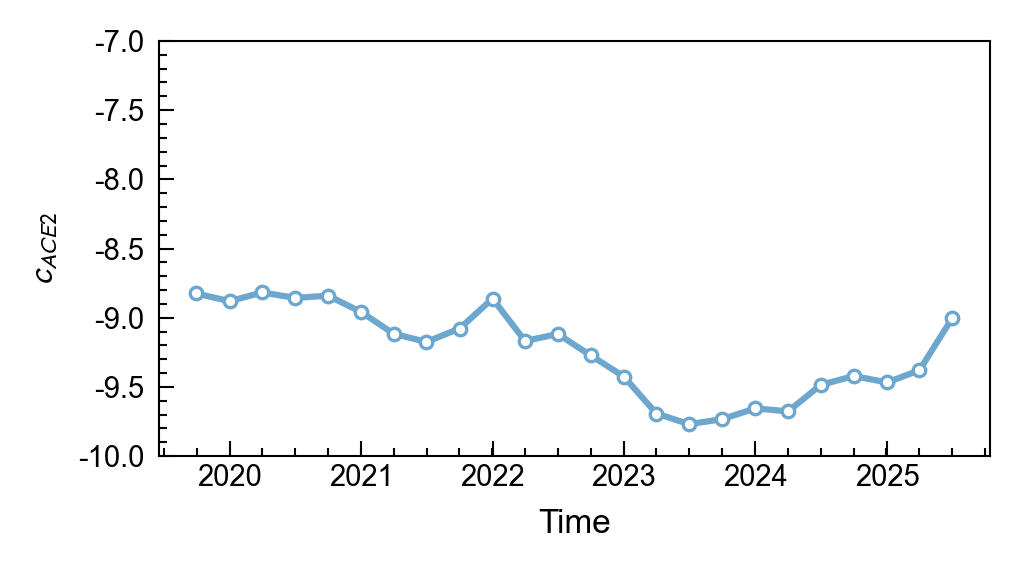

In [4]:
nature_rc()
fig = plt.figure(figsize=(3.5, 2.0)); ax = plt.gca()
ax.plot(
    ace2_per_period["time_period"], ace2_per_period["ACE2"],
    color=lighten_color("#1f77b4", 0.35), marker="o", lw=1.5, ms=3, mfc="white", mew=0.8
)
ax.set_xlabel("Time"); ax.set_ylabel(r"$c_{ACE2}$")
ax.set_ylim(-10, -7)

apply_yearly_date_axis(ax)
fig.tight_layout()
#
plt.show()


C:\Users\maria\AppData\Local\Temp\ipykernel_22228\48994572.py:9: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


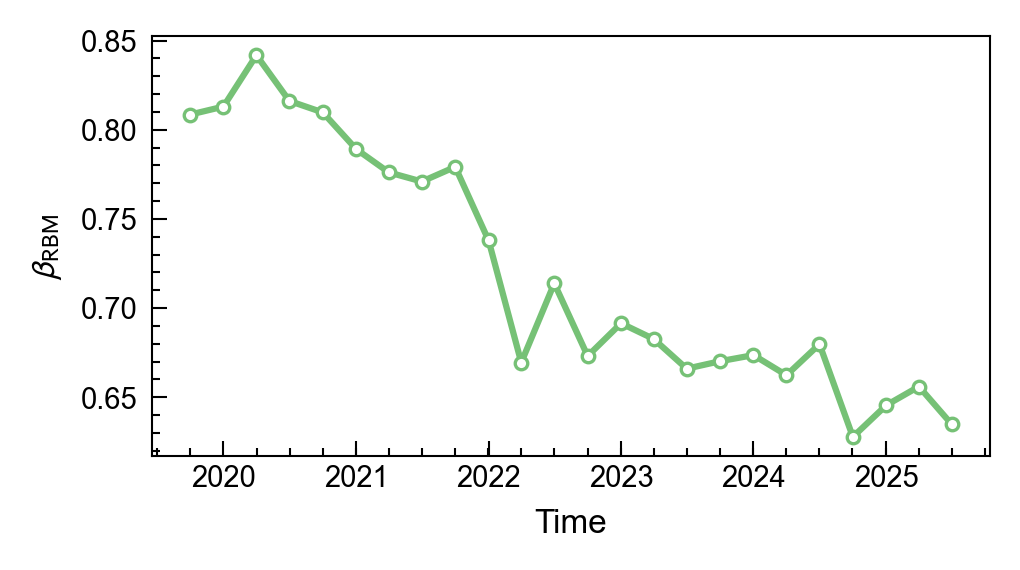

In [5]:
nature_rc()
fig = plt.figure(figsize=(3.5, 2.0)); ax = plt.gca()
ax.plot(
    beta_per_period["time_period"], beta_per_period["beta_rbm"],
    color=lighten_color("#2ca02c", 0.35), marker="o", lw=1.5, ms=3, mfc="white", mew=0.8
)
ax.set_xlabel("Time"); ax.set_ylabel(r"$\beta_{\mathrm{RBM}}$")
apply_yearly_date_axis(ax)
fig.tight_layout()
plt.show()


C:\Users\maria\AppData\Local\Temp\ipykernel_22228\2656411293.py:117: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.0)


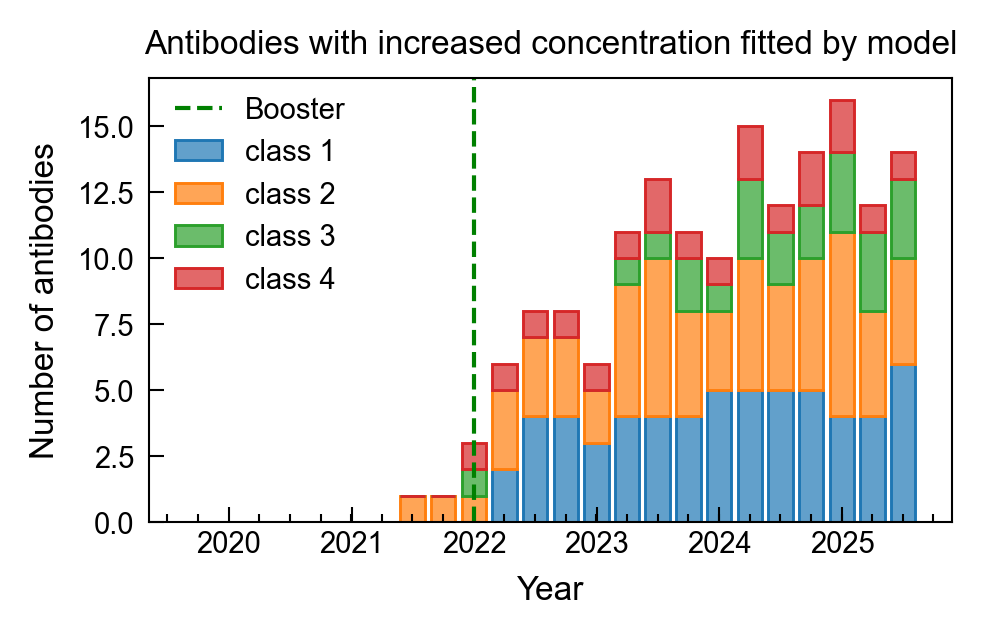

In [6]:

first_obs = (
    df_merged.sort_values(["ab_names", "time_period"])
             .groupby("ab_names", as_index=False)
             .first()[["ab_names", "conc"]]
             .rename(columns={"conc": "baseline_conc"})
)

dfb = (
    df_merged.merge(first_obs, on="ab_names", how="left")
             .assign(condition_subtype=lambda d: d["condition_subtype"].fillna("Unclassified"))
)

dfb["increased"] = dfb["conc"] > dfb["baseline_conc"]+np.log(2)

# 2.2 Count increases per class, per period
inc_counts = (
    dfb.groupby(["time_period", "condition_subtype"], dropna=False)["increased"]
       .sum()
       .reset_index(name="n_increased")
)

# Pivot for stacked bars
pivot_inc = (
    inc_counts.pivot(index="time_period", columns="condition_subtype", values="n_increased")
              .fillna(0)
              .astype(int)
              .sort_index()
)

def _order_classes(cols):
    import re as _re
    def _key(c):
        m = _re.search(r"(\d+)", str(c))
        return (0, int(m.group(1))) if m else (1, str(c).lower())
    return sorted(cols, key=_key)

class_order = _order_classes(list(pivot_inc.columns))


# 0) Apply your Nature rcParams
nature_rc()

# 1) Order classes: class 1..4 first, then others alphabetically

def _order_classes(cols):
    def _key(c):
        s = str(c)
        m = _re.search(r"(\d+)", s)
        return (0, int(m.group(1))) if m else (1, s.lower())
    return sorted(cols, key=_key)

# Make sure pivot_inc exists (built from your previous step)
pivot_inc = (
    inc_counts.pivot(index="time_period", columns="condition_subtype", values="n_increased")
              .fillna(0)
              .astype(int)
              .sort_index()
)

class_order = _order_classes(list(pivot_inc.columns))

# 2) Palette: base class colors, lightened faces + darker edges
CLASS_COLORS = {
    "class 1": "#1f77b4",
    "class 2": "#ff7f0e",
    "class 3": "#2ca02c",
    "class 4": "#d62728",
    "Unclassified": "#7f7f7f",
}
# Fallback colors (already lightened by helper)
fallback_cycle = get_lightened_cycle(len(class_order), amount=0.25)
_fallback_iter = iter(fallback_cycle)

def _base_color(cls):
    for k, v in CLASS_COLORS.items():
        if str(cls).lower() == k.lower():
            return v
    return next(_fallback_iter)

def _face_edge(cls, lighten_amt=0.35):
    base = _base_color(cls)
    face = lighten_color(base, amount=lighten_amt)
    edge = base
    return face, edge

# 3) Build bars
xdates = pivot_inc.index
x = mdates.date2num(xdates.to_pydatetime())
width_days = (0.8 * np.median(np.diff(x))) if len(x) > 1 else 28.0

fig, ax = plt.subplots(figsize=(3.35, 2.2))  # ~85 mm × 56 mm (Nature single-column)

bottom = np.zeros(len(x), dtype=float)
for cls in class_order:
    y = pivot_inc[cls].to_numpy()
    face, edge = _face_edge(cls, lighten_amt=0.30)
    ax.bar(
        x, y, bottom=bottom, width=width_days, align="center",
        color=face, edgecolor=edge, linewidth=0.7, label=str(cls)
    )
    bottom += y

# 4) Axes, ticks, legend
apply_yearly_date_axis(ax)
ax.set_ylabel("Number of antibodies")
ax.set_xlabel("Year")
#title
ax.set_title("Antibodies with increased concentration fitted by model", pad=6)
#add green vertical line end 2021 for booster
ax.axvline(x=mdates.date2num(datetime(2021,12,31)), color='green', linestyle='--', lw=1, label='Booster')

ax.tick_params(axis='y', which='minor', length=0)

# Compact legend; move slightly above plot if many classes
ax.legend( ncol=1, loc="upper left", bbox_to_anchor=(0.0, 1.02))

plt.tight_layout(pad=1.0)
plt.show()


In [7]:
pandemic_seqs=Proteins_utils.load_FASTA("../seq_data/ns_mutated_spike_100k.fasta")
logkd_mat = np.vstack([get_Kd(seq, KD_VECTORS, log10=True) for seq in pandemic_seqs])  # shape: (N_filtered, n_abs)
logkd_mat.shape#Nseq * n_abs

(3704, 29)

C:\Users\maria\AppData\Local\Temp\ipykernel_22228\2807769312.py:80: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.9)


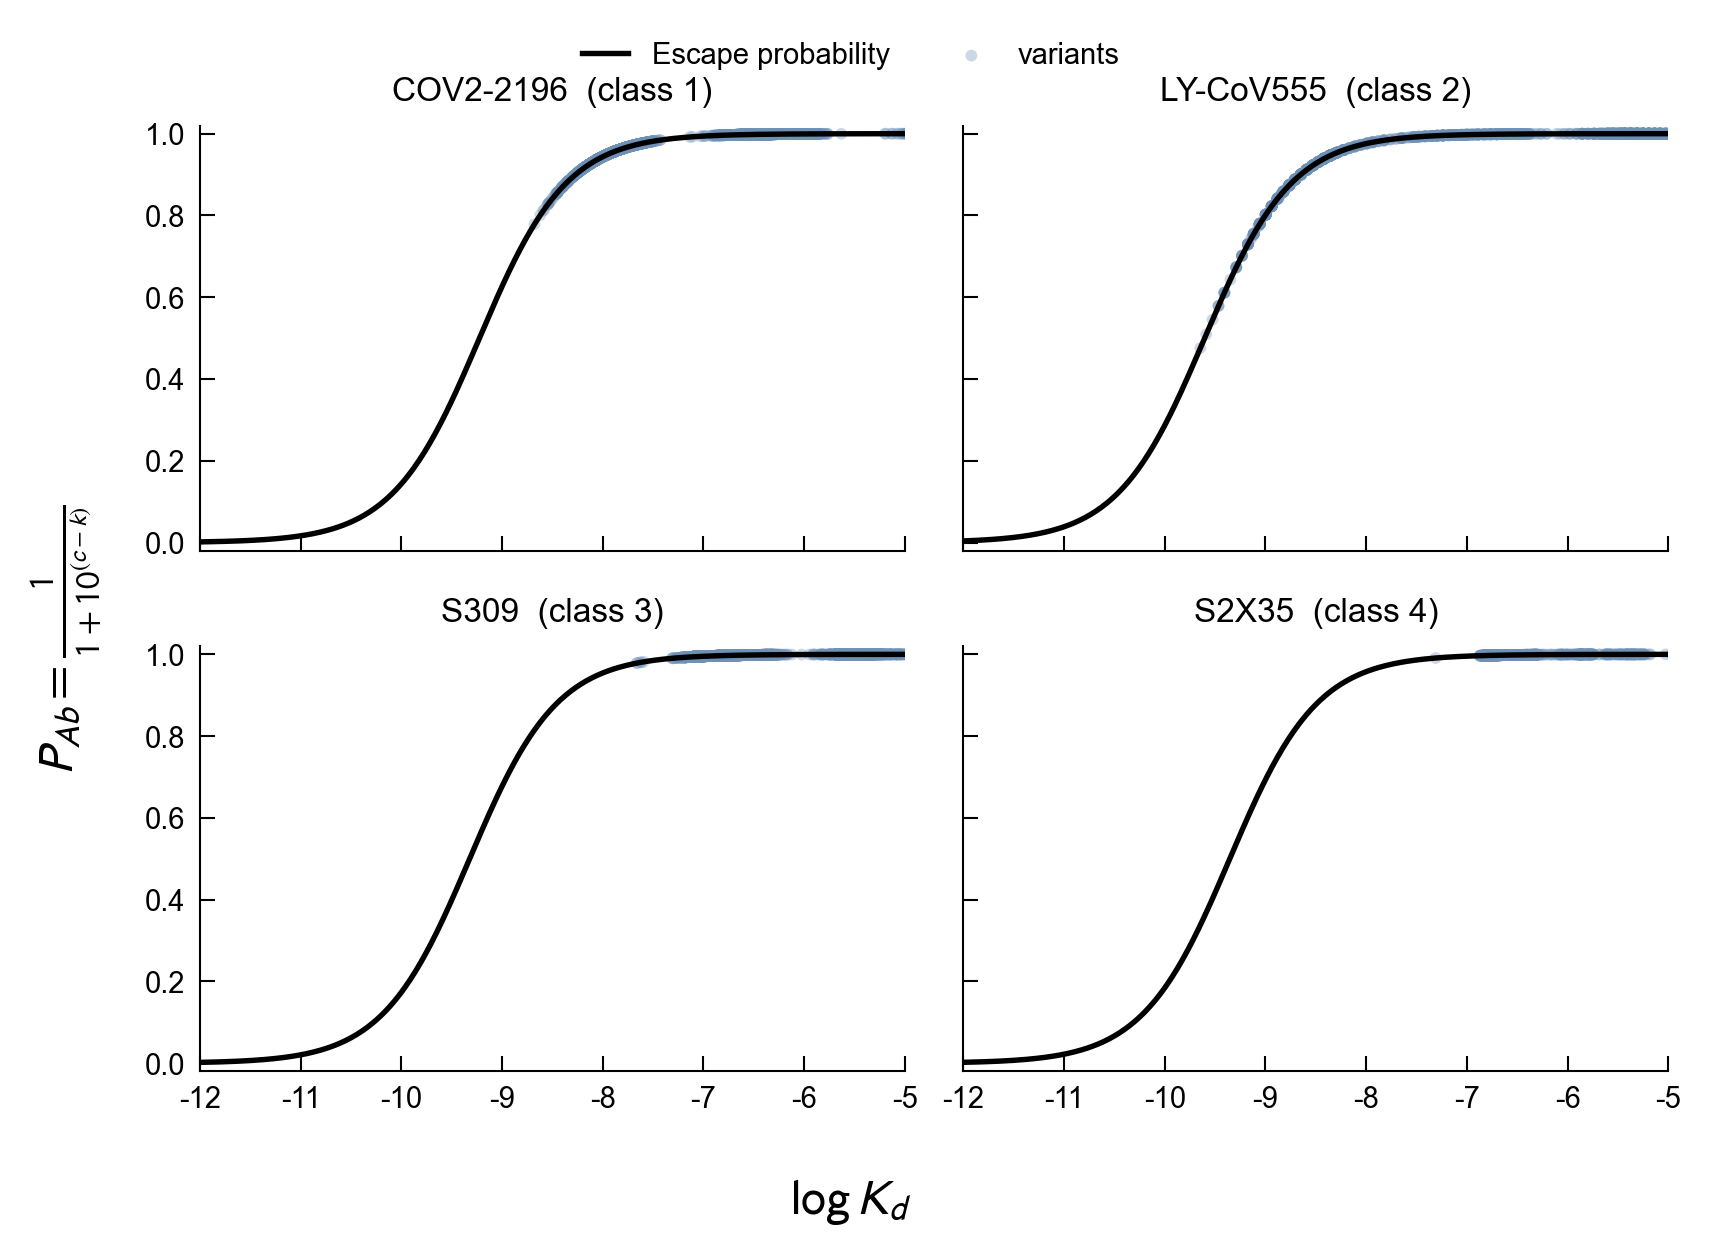

In [8]:
# --- One subplot per antibody; overlay variant points from pandemic_seqs logKd ---
my_abs = pd.Series({
    1: 'COV2-2196',
    2: "LY-CoV555",
    3: "S309",
    4: "S2X35",
})
# Make sure ab_names follows KD_VECTORS order
ab_names = list(KD_VECTORS.keys())
ab_to_idx = {name: i for i, name in enumerate(ab_names)}

# First period c-values (already clipped to [-12, -5] in df_conc creation)
first_period = df_conc["time_period"]
#ADD 6 months
first_period = df_conc["time_period"].min() 
c_first = (df_conc[df_conc["time_period"] == first_period]
           .set_index("ab_names")["conc"])

# Your 4 antibodies: use my_abs if you defined it; otherwise pick 4 present
try:
    selected_abs = [a for a in my_abs if a in c_first.index and a in ab_to_idx][:4]
except NameError:
    present = [a for a in c_first.index if a in ab_to_idx]
    selected_abs = present[:4]

if len(selected_abs) < 1:
    raise RuntimeError("No overlapping antibodies between df_conc first-period and KD_VECTORS.")

# kd grid
kd_grid = np.linspace(-12, -5, 400)

# Nature rc
nature_rc()

# Figure
fig, axes = plt.subplots(2, 2, figsize=(5.7, 4.), sharex=True, sharey=True)  # 2 columns wide
axes = axes.ravel()

for ax, ab in zip(axes, selected_abs):
    c_val = float(c_first.loc[ab])
    c_val = float(np.clip(c_val, -12.0, -5.0))

    # Curve: y = 1/(1 + 10^(c - kd))
    y_curve = 1.0 / (1.0 + np.power(10.0, (c_val - kd_grid)))
    ax.plot(kd_grid, y_curve, lw=1.3, color="k", label="Escape probability")

    # Points from pandemic_seqs for this Ab
    j = ab_to_idx[ab]
    v_logkd = logkd_mat[:, j]
    v_logkd = v_logkd[np.isfinite(v_logkd)]
    y_pts = 1.0 / (1.0 + np.power(10.0, (c_val - v_logkd)))
    ax.scatter(v_logkd, y_pts, s=8, alpha=0.35, edgecolors="none", label="variants")

    # Styling
    # build once (you already renamed 'condition' -> 'ab_names' above)
    ab_class_map = ab_class_df.set_index("ab_names")["condition_subtype"].to_dict()

    # ... inside your plotting loop ...
    cls = ab_class_map.get(ab, "Unclassified")
    ax.set_title(f"{ab}  ({cls})", fontsize=8)
# or, if you want to keep c/date too:
# ax.set_title(f"{ab}  ({cls})   c={c_val:.2f}, {first_period:%Y-%m-%d}", fontsize=8)

    ax.set_xlim(-12, -5)
    ax.set_ylim(-0.02, 1.02)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(direction="in", top=False, right=False)

# Turn off unused panels if < 4 selected
for ax in axes[len(selected_abs):]:
    ax.axis("off")

# Labels and shared legend
fig.supxlabel(r"$\log K_d$")
fig.supylabel(r"$P_{Ab}=\frac{1}{1+10^{(c-k)}}$")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout(pad=0.9)
plt.show()


# Variability of mutational landscape

In [9]:
# --- Configuration ---
EM_DIR = "../params_by_period_0.03_m1_m8_m8"
FASTA_FILE = "../seq_data/WT_single_mutants.fasta"
FIRST_PERIOD_DATE = pd.Timestamp("2020-01-01") # Used as minimum date



# Regex to parse mutation name (e.g., "BQ_M349A")
RE_MUT_NAME = re.compile(r".*_([A-Z\*]\d+[A-Z\*])$")
# ---------------------------------------------------


def parse_period_from_name(p: str) -> Optional[pd.Timestamp]:
    """Parses a YYYY-MM-DD date from a parameter file path."""
    m = re.search(r"param_period_([0-9]{4}-[0-9]{2}-[0-9]{2})\.csv$", p)
    if not m:
        return None
    return pd.to_datetime(m.group(1), format="%Y-%m-%d", errors="coerce")


def list_available_periods(em_dir: str, min_date: Optional[pd.Timestamp] = None) -> List[pd.Timestamp]:
    """Finds all valid, sorted parameter file dates in a directory."""
    files = glob.glob(f"{em_dir}/param_period_*.csv")
    periods = sorted(
        [
            parse_period_from_name(f)
            for f in files
            if parse_period_from_name(f) is not None
        ]
    )
    if min_date is not None:
        periods = [p for p in periods if p >= min_date]
    print(
        f"Found {len(periods)} model periods in {em_dir}"
    )
    return periods


def load_fasta_lists(filepath: str) -> Tuple[List[str], List[str]]:
    """
    Loads a FASTA file, preserving order.
    
    Returns:
        Tuple[List[str], List[str]]: (list_of_headers, list_of_sequences)
    """
    headers: List[str] = []
    sequences: List[str] = []
    current_seq_parts: List[str] = []
    
    try:
        with open(filepath, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                if line.startswith(">"):
                    # Save previous sequence
                    if current_seq_parts:
                        sequences.append("".join(current_seq_parts))
                    
                    # Start new sequence
                    headers.append(line[1:])  # Remove ">"
                    current_seq_parts = []
                else:
                    current_seq_parts.append(line)
        
        # Add the very last sequence
        if current_seq_parts:
            sequences.append("".join(current_seq_parts))
            
    except FileNotFoundError:
        print(f"Error: FASTA file not found at {filepath}")
        return [], []
    except Exception as e:
        print(f"Error reading FASTA file: {e}")
        return [], []

    if len(headers) != len(sequences):
        print(
            f"Warning: Mismatch in FASTA file. Found {len(headers)} headers but {len(sequences)} sequences."
        )
        min_len = min(len(headers), len(sequences))
        return headers[:min_len], sequences[:min_len]

    print(f"Loaded {len(headers)} sequences from {filepath}")
    return headers, sequences


def parse_mutation_names(headers: List[str]) -> List[str]:
    """Extracts mutation names (e.g., M349A) from FASTA headers."""
    parsed_names: List[str] = []
    for h in headers:
        m = RE_MUT_NAME.match(h)
        if m:
            parsed_names.append(m.group(1))
        else:
            print(f"Warning: Could not parse mutation name from header: {h}")
            parsed_names.append(h)  # Use full header as fallback
    return parsed_names


def extract_site(df):
    """Helper to extract site number from mutation string."""
    df['site'] = pd.to_numeric(
        df['mutation'].str.extract(r'(\d+)')[0], errors='coerce'
    )
    df = df.dropna(subset=['site'])
    df['site'] = df['site'].astype(int)
    return df

def score_period_model(
    period_date: pd.Timestamp,
    wt_seq_str: str,
    mutant_seq_list: List[str],
    mutant_names: List[str]
) -> pd.Series:
    """
    Loads a model for a period, scores WT and mutants,
    and returns delta-scores.
    """
    period_str = period_date.strftime("%Y-%m-%d")
    print(f"Processing period: {period_str}...")
    em_path = f"{EM_DIR}/param_period_{period_str}.csv"
    
    try:
        model_full = load_escape_map_from_csv(em_path)
    except Exception as e:
        print(f"  Error loading model from {em_path}: {e}")
        return pd.Series(dtype=float, name="delta_score")

    try:
        # Score WT (as a list with one element)
        wt_score_array = -model_full(wt_seq_str)
        wt_score = float(np.asarray(wt_score_array).ravel()[0])

        # Score all mutants
        mutant_scores_array = -model_full(mutant_seq_list)
        mutant_scores = np.asarray(mutant_scores_array).ravel()

        if len(mutant_scores) != len(mutant_names):
             print(f"  Error: Score count ({len(mutant_scores)}) does not match")
             print(f"  sequence count ({len(mutant_names)}). Skipping period.")
             return pd.Series(dtype=float, name="delta_score")

        # Calculate delta-scores
        delta_scores = mutant_scores - wt_score
        
        return pd.Series(delta_scores, index=mutant_names, name="delta_score")
        
    except Exception as e:
        print(f"  Error while scoring sequences for period {period_str}: {e}")
        return pd.Series(dtype=float, name="delta_score")


def get_positive_counts_by_site(delta_scores_series: pd.Series) -> pd.Series:
    """Groups delta-scores by site and counts mutations > 0."""
    if delta_scores_series.empty:
        return pd.Series(dtype=int, name="positive_count")
        
    df = delta_scores_series.reset_index()
    df.columns = ['mutation', 'delta_score']
    
    df = extract_site(df)
    
    # Filter for beneficial mutations
    beneficial_df = df[df['delta_score'] > 0]
    
    # Count per site
    site_counts = beneficial_df.groupby('site').size().rename("positive_count")
    
    return site_counts



Loaded 3382 sequences from ../seq_data/WT_single_mutants.fasta
Found 23 model periods in ../params_by_period_0.03_m1_m8_m8
Processing period: 2020-01-01...
Processing period: 2025-07-01...
site
354    1
355    0
356    0
357    0
358    0
      ..
515    0
516    0
517    0
518    0
519    9
Name: positive_count, Length: 166, dtype: int64
Generating 'Nature-ready' plot...


C:\Users\maria\AppData\Local\Temp\ipykernel_22228\607834798.py:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0)
C:\Users\maria\AppData\Local\Temp\ipykernel_22228\607834798.py:169: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.0)


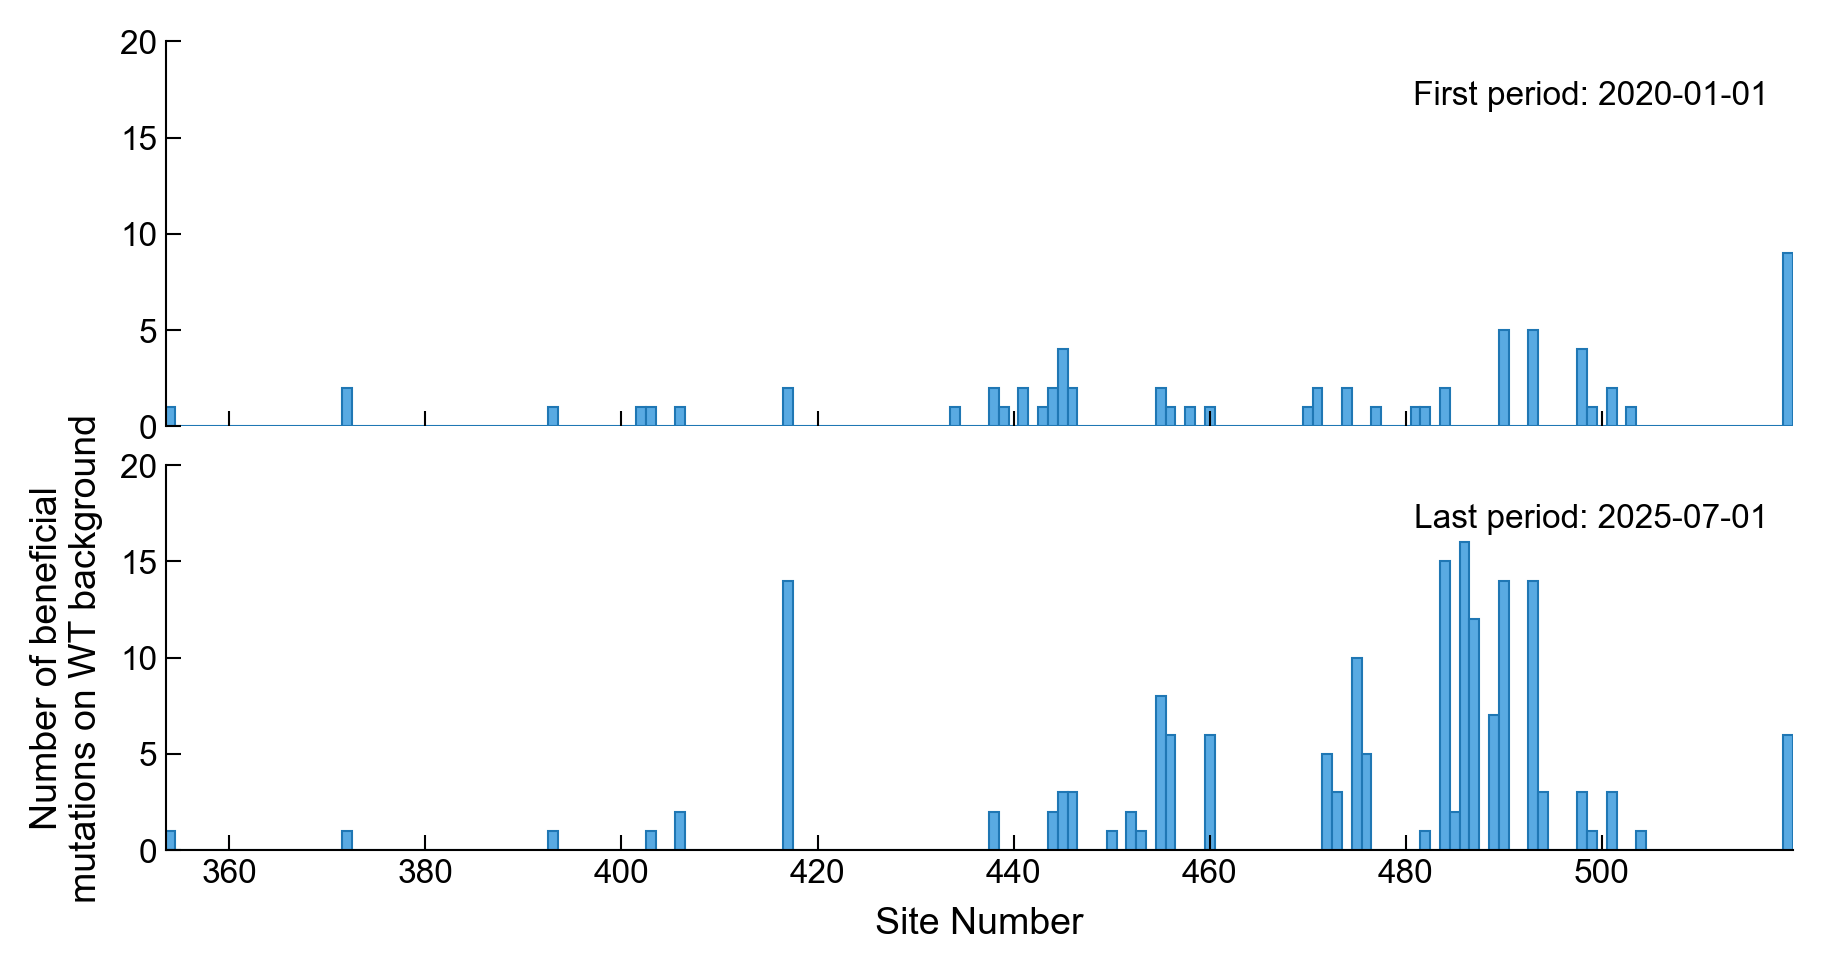

In [10]:


def set_nature_style():
    """Applies Nature-like rcParams for professional plots."""
    try:
        plt.rcParams.update({
            'font.family': 'sans-serif',
            'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
            'font.size': 8,
            'axes.labelsize': 8,
            'axes.titlesize': 8,
            'xtick.labelsize': 8,
            'ytick.labelsize': 8,
            'legend.fontsize': 8,
            'figure.dpi': 300,
            'savefig.dpi': 300,
            'axes.linewidth': 0.5,
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.pad': 2,
            'ytick.major.pad': 2,
            'lines.linewidth': 1.0,
            'patch.linewidth': 0.5,  # Edge width for bars
        })
    except Exception as e:
        print(f"Warning: Could not set all Nature rcParams. {e}")
        # Use defaults if it fails (e.g., in a weird environment)
        pass

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by mixing it with white.
    Amount = 0.0 gives original color, 1.0 gives white.
    """
    try:
        c = mcolors.to_rgb(color)
        h, l, s = colorsys.rgb_to_hls(*c)
        new_l = l + (1 - l) * amount
        return colorsys.hls_to_rgb(h, new_l, s)
    except ValueError:
        return color


def main():

    fasta_headers, fasta_sequences = load_fasta_lists(FASTA_FILE)
    if not fasta_headers:
        return  # Error already printed

    mutation_names = parse_mutation_names(fasta_headers)

    # --- 3. Find First and Last Periods ---
    time_periods = list_available_periods(EM_DIR, min_date=FIRST_PERIOD_DATE)
    if len(time_periods) < 2:
        print(f"Error: Need at least two model periods in {EM_DIR} to compare.")
        return
        
    first_period = time_periods[0]
    last_period = time_periods[-1]
 
    fasta_sequences = Proteins_utils.load_FASTA(FASTA_FILE, drop_duplicates=False)

    # --- 4. Score and Process Data ---
    deltas_first = score_period_model(
        first_period, WT_SEQ, fasta_sequences, mutation_names
    )
    deltas_last = score_period_model(
        last_period, WT_SEQ, fasta_sequences, mutation_names
    )

    if deltas_first.empty or deltas_last.empty:
        print("Error processing one or both periods. Cannot generate plot.")
        return
        
    counts_first = get_positive_counts_by_site(deltas_first)
    counts_last = get_positive_counts_by_site(deltas_last)
    
    # --- 5. Prepare Data for Plotting ---
    # Get the full range of sites
    all_sites = set(counts_first.index) | set(counts_last.index)
    if not all_sites:
        print("No beneficial mutations found in any period. Exiting.")
        return
        
    min_site = min(all_sites)
    max_site = max(all_sites)
    site_index = pd.Index(range(min_site, max_site + 1), name="site")
    
    # Reindex to full site range, filling missing sites with 0
    counts_first = counts_first.reindex(site_index, fill_value=0)
    print(counts_first)
    counts_last = counts_last.reindex(site_index, fill_value=0)

    # --- 6. Plot (Nature Ready Version) ---
    print("Generating 'Nature-ready' plot...")
    
    # Apply professional styling
    set_nature_style()
    
    # Define colors (using style from your reference)
    BASE_COLOR = "#1f77b4" # Standard "Tableau blue"
    FACE_COLOR = lighten_color(BASE_COLOR, amount=0.35)
    EDGE_COLOR = BASE_COLOR

    fig, (ax1, ax2) = plt.subplots(
        2, 1, 
        figsize=(7, 3.5), # ~178mm x 89mm (2-column width)
        sharex=True,      # Both plots share the same x-axis
        gridspec_kw={'hspace': 0.1}, # Reduce space between plots
    )

    # --- Top plot: First Period ---
    ax1.bar(
        counts_first.index, counts_first.values, width=1.0,
        color=FACE_COLOR, edgecolor=EDGE_COLOR
    )
    # Remove y-label to avoid redundancy
    ax1.set_ylabel(None) 
    
    # Add panel label 'a' and date annotation
    # ax1.text(0.015, 0.9, "a", transform=ax1.transAxes,
    #          fontsize=10, fontweight='bold', va='top', ha='left')
    ax1.text(0.985, 0.9, f"First period: {first_period.date()}", 
             transform=ax1.transAxes, va='top', ha='right')

    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["bottom"].set_visible(False) # Hide bottom spine, as ax2 has it
    ax1.set_ylim(bottom=0)
    
    # --- Bottom plot: Last Period ---
    ax2.bar(
        counts_last.index, counts_last.values, width=1.0,
        color=FACE_COLOR, edgecolor=EDGE_COLOR
    )
    
    # Add panel label 'b' and date annotation
    # ax2.text(0.015, 0.9, "b", transform=ax2.transAxes,
    #          fontsize=10, fontweight='bold', va='top', ha='left')
    ax2.text(0.985, 0.9, f"Last period: {last_period.date()}", 
             transform=ax2.transAxes, va='top', ha='right')
    
    # Set shared labels
    ax2.set_ylabel("Number of beneficial\nmutations on WT background", fontsize=9, labelpad=4)
    ax2.set_xlabel("Site Number", fontsize=9, labelpad=4)
    
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.set_ylim(bottom=0)
    
    # --- Final Axis Formatting ---
    
    # Set x-axis limits to tightly frame the data
    ax2.set_xlim(min_site - 0.5, max_site + 0.5)
    
    # Ensure both plots share the exact same y-axis scale
    max_y = max(counts_first.max(), counts_last.max())
    # Add 10% headroom, rounded up
    ylim_top = ceil((max_y * 1.1) / 5) * 5 if max_y > 5 else ceil(max_y * 1.1) 
    
    ax1.set_ylim(0, ylim_top)
    ax2.set_ylim(0, ylim_top)
    
    # Use major ticks and remove minor ticks on y-axis for clarity
    ax1.tick_params(axis='y', which='minor', length=0)
    ax2.tick_params(axis='y', which='minor', length=0)
    
    # Use tight_layout for good default spacing
    plt.tight_layout(pad=1.0)
    
    # Show and save plot
    # plt.savefig("beneficial_mutations_by_site.pdf", bbox_inches='tight')
    plt.show()


if __name__ == "__main__":
    main()